In [2]:
# import libraries
import math
import scipy
import numpy as np
import matplotlib as mpl
import scipy.integrate as integrate
import matplotlib.colors as colors
import matplotlib.cm as cmx
import pandas as pd
import seaborn as sns
from scipy.stats import skewnorm
from scipy.optimize import curve_fit
from scipy.integrate import odeint
%matplotlib inline
import matplotlib.pyplot as plt

import re
import h5py
from scipy.interpolate import interp1d
import glob

from scipy import signal
from scipy import optimize, signal
from symfit import Parameter, Variable
from symfit import Fit
#from symfit import NumericalLeastSquares
from symfit import parameters, variables, D, ODEModel, exp
from symfit.core.minimizers import BasinHopping
#from symfit.core.objectives import LogLikelihood
%matplotlib inline
%config InlineBackend.figure_format = 'svg'


# constants in SI
m_e = 9.10938291E-31 # mass of electron
e_charge = 1.60217657E-19 # charge of electron
eV = 1.60217657E-19 # 1 electron volt in joules
ε_0 = 8.85418782E-12 # permittivity of free space
h = 6.62606957E-34 # planck number
h_ev = 4.135667662E-15 #Plank number eV.s
hbar = 1.054571800E-34 # reduced planck constant
Rydberg = 2.1787E-18 # Rydberg energy (in joules)
avogadro = 6.02214179E23
c = 299792458 # m/s
sigma_ev = 3.54E11 #ev/m^2/s/K^4
sigma = 5.670367E-8 #J/m^2/s/K^4
# units in SI
Å = 1E-10 # m to angstrom
k_b = 1.38064852E-23 #J/K
k_ev = 8.6173303E-5 #ev/K

def peak_max(x_array,y_array, valuerange_low, valuerange_high):
    idx_lo = (np.abs(x_array - valuerange_low)).argmin()
    idx_hi = (np.abs(x_array - valuerange_high)).argmin()
    max_peak = max(y_array[idx_lo:idx_hi])
    return max_peak
def find_nearest_idx(array, value):
    #array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
def find_zero_idx_range(xarray,y1, y2,xmin,xmax):
    i1 = find_nearest_idx(xarray,xmin)
    i2 = find_nearest_idx(xarray,xmax)
    idx_zero = find_nearest_idx((y1[i1:i2]-y2[i1:i2]),0)
    return idx_zero
def background_f(x_array,y_array, valuerange_low, valuerange_high):
    idx_lo = (np.abs(x_array - valuerange_low)).argmin()
    idx_hi = (np.abs(x_array - valuerange_high)).argmin()
    background_val = np.mean(y_array[idx_lo:idx_hi])
    return background_val

In [50]:
kinetic_data = np.genfromtxt("charge_exciton_kinetics_GA_700nm_just_charge_mask.csv",delimiter=',',skip_header = 1)
tt_data_1 = kinetic_data[:,0]
tt_data_2 = (tt_data_1*np.ones((4,tt_data_1.size))).T

exciton_data = kinetic_data[:,1::2]
charge_data = kinetic_data[:,2::2]

##sort time zeros
tt_data = tt_data_2
tt_data[:,0] = tt_data_2[:,0]-.2
tt_data[:,1] = tt_data_2[:,1]-.12
tt_data[:,2] = tt_data_2[:,2]+.05
tt_data[:,3] = tt_data_2[:,3]#+.1
#change units to mm^3 ps-1 rather than cm^3 s-1
t_0 = 2.5 #set time to model from

norm_mult = 1.02

t_0_idx = find_nearest_idx(tt_data[:,0],t_0)
exciton_1 = norm_mult*exciton_data[t_0_idx:,0]/max(exciton_data[t_0_idx:,0])
exciton_2 = norm_mult*exciton_data[t_0_idx:,1]/max(exciton_data[t_0_idx:,1])
exciton_3 = norm_mult*exciton_data[t_0_idx:,2]/max(exciton_data[t_0_idx:,2])
t_data1 = (tt_data[t_0_idx:,0]-t_0)*1e-12
charge_1 = norm_mult*charge_data[t_0_idx:,0]/max(charge_data[t_0_idx:,0])
charge_2 = norm_mult*charge_data[t_0_idx:,1]/max(charge_data[t_0_idx:,1])
charge_3 = norm_mult*charge_data[t_0_idx:,2]/max(charge_data[t_0_idx:,2])


t_data1 = (tt_data[t_0_idx:,0]-t_0)

In [51]:

#t_0 = 2.5 #set time to model from

#norm_mult = 1.02

# t_0_idx = find_nearest_idx(tt_data[:,0],t_0)
# exciton_1 = norm_mult*exciton_data[t_0_idx:,0]/max(exciton_data[t_0_idx:,0])
# exciton_2 = norm_mult*exciton_data[t_0_idx:,1]/max(exciton_data[t_0_idx:,1])
# exciton_3 = norm_mult*exciton_data[t_0_idx:,2]/max(exciton_data[t_0_idx:,2])
# t_data1 = (tt_data[t_0_idx:,0]-t_0)*1e-12
# charge_1 = norm_mult*charge_data[t_0_idx:,0]/max(charge_data[t_0_idx:,0])
# charge_2 = norm_mult*charge_data[t_0_idx:,1]/max(charge_data[t_0_idx:,1])
# charge_3 = norm_mult*charge_data[t_0_idx:,2]/max(charge_data[t_0_idx:,2])



#t_data1 = (tt_data[t_0_idx:,0]-t_0)
# a1_c = Parameter('a_c',value =1/(1030),min = 0,absolute_sigma = False, fixed =True)
# b_fuse = Parameter('b_fuse', value = 0.5e-8*1e-12*1e3,min = 0,absolute_sigma = False, fixed = True)#1.45e-11*1e12
# b_non = Parameter('b_non', value = 1e-8*1e-12*1e3,min = 0,absolute_sigma = False, fixed = False)#1.45e-11*1e12
# C_c = Parameter('C_c', value =0,min = 0,fixed = True)#.000551e-28,min = 0,fixed = True)
# b_ex_c = Parameter('b_ex_c', value = 1e-8*1e-12*1e3,min = 0,absolute_sigma = False,fixed = True)#.495e-11,min = 0,fixed = False)
# a_ex_non =Parameter('a_ex_non', value = (1/(395)),min = 0,absolute_sigma = False,fixed = False)#1/(280)
# a_split = Parameter('a_split', value =(1/(1200)),min = 0,absolute_sigma = False,fixed = True)#1/(120e-12)
# b_ex = Parameter('b_ex', value = 0.2e-8*1e-12*1e3,min = 0,absolute_sigma = False,fixed = True)##2.2e-11*1e12
# C_ex = Parameter('C_ex',value = 0,min = 0,fixed = True)#.000551e-28,min = 0,fixed = True)
# a_ex_rad = Parameter('a_ex_rad',value =1/3400,min = 0,fixed = True)#1e6,min = 0,fixed = True)

# b_ex_init = 0#6e-8*1e-12*1e3
# t_ann_ex = 10
# b_fuse_init = 0#2.3e-8*1e-12*1e3
# t_ann_c = 5

# charges1,excitons1,t,charges2,excitons2,charges3,excitons3 = variables('charges1,excitons1,t,charges2,excitons2,charges3,excitons3')

# wavelength = 700e-9
# thickness = 130e-9
# k = 1.3 #from kerremans, Armin et al. 
# alpha = 4*np.pi*k/wavelength
# OD = -np.log10(np.exp(-alpha*thickness))
# absorb = (1-10**(-OD))
# reprate = 1500
# FWHM = 400e-6
# power1 = 0.8e-6
# power2 = 4.5e-6
# power3 = 18e-6
# nn1 = absorb*0.95*power1/((h*c/wavelength)*np.pi*(FWHM/2)**2*thickness*reprate)*1e-9
# nn2 = absorb*0.95*power2/((h*c/wavelength)*np.pi*(FWHM/2)**2*thickness*reprate)*1e-9
# nn3 = absorb*0.95*power3/((h*c/wavelength)*np.pi*(FWHM/2)**2*thickness*reprate)*1e-9


# R_init = 0.45#R_init_guess
# charge_data1 = nn1*R_init*charge_1
# exciton_data1 = nn1*(1-R_init)*exciton_1
# charge_data2 = nn2*R_init*charge_2
# exciton_data2 = nn2*(1-R_init)*exciton_2
# charge_data3 = nn3*R_init*charge_3
# exciton_data3 = nn3*(1-R_init)*exciton_3

# data = [charge_data1,charge_data2,charge_data3,exciton_data1,exciton_data2,exciton_data3]
# values = range(len(data))
# #a_c,b_fuse,C_c, b_ex_c,a_ex,a_split,b_ex,C_ex = parameters('a_c,b_fuse,C_c, b_ex_c,a_ex,a_split,b_ex,C_ex')


# model = {
#     D(charges1,t):  -(a_c*charges1+((b_fuse_init*exp(-t/t_ann_c)+b_fuse)+b_non)*charges1**2+C_c*charges1**3-2*a_split*excitons1+0*charges1*excitons1),
#     D(excitons1,t): -(b_ex_c*charges1*excitons1+(a_ex_non+a_split+a_ex_rad)*excitons1+(b_ex_init*exp(-t/t_ann_ex)+b_ex)*excitons1**2+C_ex*excitons1**3-.5*b_fuse*charges1**2),
#     D(charges2,t):  -(a_c*charges2+((b_fuse_init*exp(-t/t_ann_c)+b_fuse)+b_non)*charges2**2+C_c*charges2**3-2*a_split*excitons2+0*charges2*excitons2),
#     D(excitons2,t): -(b_ex_c*charges2*excitons2+(a_ex_non+a_split+a_ex_rad)*excitons2+(b_ex_init*exp(-t/t_ann_ex)+b_ex)*excitons2**2+C_ex*excitons2**3-.5*b_fuse*charges2**2),
#     D(charges3,t):  -(a_c*charges3+((b_fuse_init*exp(-t/t_ann_c)+b_fuse)+b_non)*charges3**2+C_c*charges3**3-2*a_split*excitons3+0*charges3*excitons3),
#     D(excitons3,t): -(b_ex_c*charges3*excitons3+(a_ex_non+a_split+a_ex_rad)*excitons3+(b_ex_init*exp(-t/t_ann_ex)+b_ex)*excitons3**2+C_ex*excitons3**3-.5*b_fuse*charges3**2),
# }

# ode_model = ODEModel(model, initial={t: 0, charges1: nn1*R_init, excitons1:nn1*(1-R_init),charges2: nn2*R_init, excitons2:nn2*(1-R_init),charges3: nn3*R_init, excitons3: nn3*(1-R_init)})



a1_c = Parameter('a1_c',value =1/(1030),min = 0,absolute_sigma = False, fixed =True)
b1_fuse = Parameter('b1_fuse', value = 0.5e-8*1e-12*1e3,min = 0,absolute_sigma = False, fixed = True)#1.45e-11*1e12
b1_non = Parameter('b1_non', value = 1e-8*1e-12*1e3,min = 0,absolute_sigma = False, fixed = False)#1.45e-11*1e12
C1_c = Parameter('C1_c', value =0,min = 0,fixed = True)#.000551e-28,min = 0,fixed = True)
b1_ex_c = Parameter('b1_ex_c', value = 1e-8*1e-12*1e3,min = 0,absolute_sigma = False,fixed = True)#.495e-11,min = 0,fixed = False)
a1_ex_non =Parameter('a1_ex_non', value = (1/(395)),min = 0,absolute_sigma = False,fixed = False)#1/(280)
a1_split = Parameter('a1_split', value =(1/(1200)),min = 0,absolute_sigma = False,fixed = True)#1/(120e-12)
b1_ex = Parameter('b1_ex', value = 0.2e-8*1e-12*1e3,min = 0,absolute_sigma = False,fixed = True)##2.2e-11*1e12
C1_ex = Parameter('C1_ex',value = 0,min = 0,fixed = True)#.000551e-28,min = 0,fixed = True)
a1_ex_rad = Parameter('a1_ex_rad',value =1/3400,min = 0,fixed = True)#1e6,min = 0,fixed = True)


charges1,excitons1,t,charges2,excitons2,charges3,excitons3 = variables('charges1,excitons1,t,charges2,excitons2,charges3,excitons3')

wavelength = 700e-9
thickness = 110e-9
k = 1.2 #from kerremans, Armin et al. 
alpha = 4*np.pi*k/wavelength
OD = 0.55 #from expt # OR#-np.log10(np.exp(-alpha*thickness))#
absorb = (1-10**(-OD))
reprate = 1500
FWHM = 550e-6
power1 = 0.8e-6
power2 = 4.5e-6
power3 = 18e-6
nn1 = absorb*0.85*power1/((h*c/wavelength)*np.pi*(FWHM/2)**2*thickness*reprate)*1e-9
nn2 = absorb*0.85*power2/((h*c/wavelength)*np.pi*(FWHM/2)**2*thickness*reprate)*1e-9
nn3 = absorb*0.85*power3/((h*c/wavelength)*np.pi*(FWHM/2)**2*thickness*reprate)*1e-9


R_init = 0.45#R_init_guess
charge_data1 = nn1*R_init*charge_1
exciton_data1 = nn1*(1-R_init)*exciton_1
charge_data2 = nn2*R_init*charge_2
exciton_data2 = nn2*(1-R_init)*exciton_2
charge_data3 = nn3*R_init*charge_3
exciton_data3 = nn3*(1-R_init)*exciton_3

data = [charge_data1,charge_data2,charge_data3,exciton_data1,exciton_data2,exciton_data3]
values = range(len(data))
#a_c,b_fuse,C_c, b_ex_c,a_ex,a_split,b_ex,C_ex = parameters('a_c,b_fuse,C_c, b_ex_c,a_ex,a_split,b_ex,C_ex')


model = {
    D(charges1,t):  -(a1_c*charges1+((b1_fuse)+b1_non)*charges1**2+C1_c*charges1**3-2*a1_split*excitons1+0*charges1*excitons1),
    D(excitons1,t): -(b1_ex_c*charges1*excitons1+(a1_ex_non+a1_split+a1_ex_rad)*excitons1+(b1_ex)*excitons1**2+C1_ex*excitons1**3-.5*b1_fuse*charges1**2),
    D(charges2,t):  -(a1_c*charges2+((b1_fuse)+b1_non)*charges2**2+C1_c*charges2**3-2*a1_split*excitons2+0*charges2*excitons2),
    D(excitons2,t): -(b1_ex_c*charges2*excitons2+(a1_ex_non+a1_split+a1_ex_rad)*excitons2+(b1_ex)*excitons2**2+C1_ex*excitons2**3-.5*b1_fuse*charges2**2),
    D(charges3,t):  -(a1_c*charges3+((b1_fuse)+b1_non)*charges3**2+C1_c*charges3**3-2*a1_split*excitons3+0*charges3*excitons3),
    D(excitons3,t): -(b1_ex_c*charges3*excitons3+(a1_ex_non+a1_split+a1_ex_rad)*excitons3+(b1_ex)*excitons3**2+C1_ex*excitons3**3-.5*b1_fuse*charges3**2),
}

ode_model = ODEModel(model, initial={t: 0, charges1: nn1*R_init, excitons1:nn1*(1-R_init),charges2: nn2*R_init, excitons2:nn2*(1-R_init),charges3: nn3*R_init, excitons3: nn3*(1-R_init)})


In [79]:
from collections import OrderedDict

n_points = 3


# a_c = Parameter('a_c',value =1/(1030),min = 0,absolute_sigma = False, fixed =True)
# b_fuse = Parameter('b_fuse', value = 0.5e-8*1e-12*1e3,min = 0,absolute_sigma = False, fixed = True)#1.45e-11*1e12
# b_non = Parameter('b_non', value = 1e-8*1e-12*1e3,min = 0,absolute_sigma = False, fixed = False)#1.45e-11*1e12
# C_c = Parameter('C_c', value =0,min = 0,fixed = True)#.000551e-28,min = 0,fixed = True)
# b_ex_c = Parameter('b_ex_c', value = 1e-8*1e-12*1e3,min = 0,absolute_sigma = False,fixed = True)#.495e-11,min = 0,fixed = False)
# a_ex_non =Parameter('a_ex_non', value = (1/(395)),min = 0,absolute_sigma = False,fixed = False)#1/(280)
# a_split = Parameter('a_split', value =(1/(1200)),min = 0,absolute_sigma = False,fixed = True)#1/(120e-12)
# b_ex = Parameter('b_ex', value = 0.2e-8*1e-12*1e3,min = 0,absolute_sigma = False,fixed = True)##2.2e-11*1e12
# C_ex = Parameter('C_ex',value = 0,min = 0,fixed = True)#.000551e-28,min = 0,fixed = True)
# a_ex_rad = Parameter('a_ex_rad',value =1/3400,min = 0,fixed = True)#1e6,min = 0,fixed = True)


# init_params = OrderedDict([('C_c', 0),
#              ('C_ex', 0),
#              ('b_non', 1e-8*1e-12*1e3),
#              ('a_c', 1/1100),
#              ('a_ex_non', 1/295),
#              ('a_ex_rad', 1/2600),
#              ('b_ex', 2.6e-8*1e-12*1e3), 
#              ('a_split', 1/1700),
#              ('b_ex_c', 3.2e-8*1e-12*1e3),
#              ('b_fuse', 6e-8*1e-12*1e3)])


a_c_m = np.linspace(1/750, 1/2550, n_points)
b_non_m = np.linspace(.2e-8*1e-12*1e3,8e-8*1e-12*1e3, n_points)
b_ex_m = np.linspace(.2e-8*1e-12*1e3,8e-8*1e-12*1e3, n_points)
b_fuse_m = np.linspace(.2e-8*1e-12*1e3,14e-8*1e-12*1e3, n_points)
a_split_m = np.linspace(1/800, 1/6000, n_points)
b_ex_c_m = np.linspace(.1e-8*1e-12*1e3,6e-8*1e-12*1e3, n_points)
C1_c_m = np.linspace(45e-27*1e-12*1e6,655e-27*1e-12*1e6, n_points)
C1_ex_m = np.linspace(5e-27*1e-12*1e6,245e-27*1e-12*1e6, n_points)

p_frac = .15
R_init = .45

ts = np.linspace(0, 1e-8, 100)
charge_i = find_nearest_idx(ts,FWHM)

N_ph = 1e15*np.logspace(1,2,num = 2) ## density in cm3

variance = []
charge_ratio_low = []
charge_ratio_1sun = []

a1_c = Parameter('a1_c',value =1/(1030),min = 0,absolute_sigma = False, fixed =True)
b1_fuse = Parameter('b1_fuse', value = 0.5e-8*1e-12*1e3,min = 0,absolute_sigma = False, fixed = True)#1.45e-11*1e12
b1_non = Parameter('b1_non', value = 1e-8*1e-12*1e3,min = 0,absolute_sigma = False, fixed = False)#1.45e-11*1e12
C1_c = Parameter('C1_c', value =0,min = 0,fixed = True)#.000551e-28,min = 0,fixed = True)
b1_ex_c = Parameter('b1_ex_c', value = 1e-8*1e-12*1e3,min = 0,absolute_sigma = False,fixed = True)#.495e-11,min = 0,fixed = False)
a1_ex_non =Parameter('a1_ex_non', value = (1/(395)),min = 0,absolute_sigma = False,fixed = False)#1/(280)
a1_split = Parameter('a1_split', value =(1/(1200)),min = 0,absolute_sigma = False,fixed = True)#1/(120e-12)
b1_ex = Parameter('b1_ex', value = 0.2e-8*1e-12*1e3,min = 0,absolute_sigma = False,fixed = True)##2.2e-11*1e12
C1_ex = Parameter('C1_ex',value = 0,min = 0,fixed = True)#.000551e-28,min = 0,fixed = True)
a1_ex_rad = Parameter('a1_ex_rad',value =1/3400,min = 0,fixed = True)#1e6,min = 0,fixed = True)


charges1,excitons1,t,charges2,excitons2,charges3,excitons3 = variables('charges1,excitons1,t,charges2,excitons2,charges3,excitons3')


FWHM = 600e-12
tc = FWHM
sigma = FWHM/2.355


In [75]:
charge_i

6

In [76]:
ts[charge_i]

6.06060606060606e-10

In [85]:
p_frac = .15
for b_non1 in b_non_m:
    for a_c1 in a_c_m:
        for b_ex1 in b_ex_m:
            for a_split1 in a_split_m:
                for b_ex_c1 in b_ex_c_m:
                    for b_fuse1 in b_fuse_m:
                        for C1_c1 in C1_c_m:
                            for C1_ex1 in C1_ex_m:
                                init_params = OrderedDict([('C1_c',C1_c1),
                                             ('C1_ex', C1_ex1),
                                             ('b1_non', b_non1),
                                             ('a1_c', a_c1),
                                             ('a1_ex_non', 1/245),
                                             ('a1_ex_rad', 1/3000),
                                             ('b1_ex', b_ex1), 
                                             ('a1_split', a_split1),
                                             ('b1_ex_c', b_ex_c1),
                                             ('b1_fuse', b_fuse1)])

                                C_c = list(init_params.values())[0]*1e6  #.00002e-28
                                C_ex = list(init_params.values())[1]*1e6 #0.00002e-28
                                b_non = list(init_params.values())[2]*1e9
                                a_c = list(init_params.values())[3]*1e12  #1/(1030e-12)
                                a_ex_non_rad = list(init_params.values())[4]*1e12  #1/(510e-12)
                                a_ex_rad = list(init_params.values())[5]*1e12  #1/(1200e-12)
                                b_ex = list(init_params.values())[6]*1e9  #5500e-11
                                a_split = list(init_params.values())[7]*1e12 #1/(500e-12)
                                b_ex_c = list(init_params.values())[8]*1e9 #100e-11
                                b_fuse = list(init_params.values())[9]*1e9# 1.7e-8

                                a_ex = a_split+a_ex_rad+a_ex_non_rad



                                def dP_dt(P,t,G):
                                    G1 = G[0]*np.exp(-(t-tc)**2/(2*sigma**2))/(FWHM*1.5)
                                    G2 = G[1]*np.exp(-(t-tc)**2/(2*sigma**2))/(FWHM*1.5)
                                    return [-(a_c*P[0]+(b_fuse+b_non)*P[0]**2-0.0*b_ex*P[1]**2+C_c*P[0]**3-2*a_split*P[1]-0.5*b_ex_c*P[0]*P[1]-G1),-(b_ex_c*P[0]*P[1]-G2+a_ex*P[1]+b_ex*P[1]**2+C_ex*P[1]**3-.5*(1-p_frac)*b_fuse*P[0]**2)]

                                PLQE_sim = []
                                charge_ratio = []
                                carrier_tot = []
                                for nn in N_ph:
                                    P0 = [0, 0]#P0 = [nn*R_init, nn*(1-R_init)]
                                    G = [nn*R_init,nn*(1-R_init)]
                                    Ps = odeint(dP_dt, P0, ts, args = (G,))
                                    charges = Ps[:,0]
                                    excitons = Ps[:,1]
                                    #PLQE_theory_n = ((a_ex_rad*excitons+p_frac*b_fuse*charges**2)/(b_ex_c*charges*excitons-.5*(1-p_frac)*b_fuse*charges**2+a_ex*excitons+1*b_ex*excitons**2+C_ex*excitons**3+a_c*charges+C_c*charges**3-2*a_split*excitons+(b_non+b_fuse)*charges**2))#+((p_frac*b_fuse*charges**2)/(a_c*charges+C_c*charges**3-2*a_split*excitons+(b_non+b_fuse)*charges**2))
                                    #PLQE_theory_n = ((a_ex_rad*excitons+p_frac*b_fuse*charges**2)/(b_ex_c*charges*excitons-.5*(1-p_frac)*b_fuse*charges**2+a_ex*excitons+1*b_ex*excitons**2+C_ex*excitons**3+a_c*charges+C_c*charges**3-2*a_split*excitons+(b_non+b_fuse)*charges**2))#+((p_frac*b_fuse*charges**2)/(a_c*charges+C_c*charges**3-2*a_split*excitons+(b_non+b_fuse)*charges**2))
                                    rad_tot = np.trapz(a_ex_rad*excitons+p_frac*b_fuse*charges**2,ts)#a_ex_rad*excitons+
                                    tot_events = nn#np.trapz((b_ex_c*charges*excitons-.5*(1-p_frac)*b_fuse*charges**2+a_ex*excitons+1*b_ex*excitons**2+C_ex*excitons**3+a_c*charges+C_c*charges**3-2*a_split*excitons+(b_non+b_fuse)*charges**2),ts)
                                    #PLQE_theory_n = ((a_ex_rad*excitons+p_frac*b_fuse*charges**2)/(a_c*charges+C_c*charges**3+b_ex_c*charges*excitons-2*a_split*excitons+(b_non+b_fuse)*charges**2-.5*(1-p_frac)*b_fuse*charges**2+a_ex*excitons+1*b_ex*excitons**2+C_ex*excitons**3))
                                    PLQE_theory_n = rad_tot/tot_events
                                    
                                    charge_ratio = np.append(charge_ratio,(charges[charge_i]/(charges[charge_i]+excitons[charge_i])))
                                    carrier_tot = np.append(carrier_tot,(charges[charge_i]+excitons[charge_i]))
                                    #PLQE_sim = np.append(PLQE_sim,PLQE_theory_n[-1])
                                    PLQE_sim = np.append(PLQE_sim,PLQE_theory_n)

        #                         PLQE_sim = []
        #                         charge_ratio = []
        #                         P0=[]
        #                         for nn in N_ph:
        #                             P0 = [nn*R_init, nn*(1-R_init)]
        #                             G = [P0[0]/600e-12,P0[1]/600e-12]
        #                             Ps = odeint(dP_dt, P0, ts, args = (G,))
        #                             charges = Ps[:,0]
        #                             excitons = Ps[:,1]
        #                             PLQE_theory_n = ((a_ex_rad*excitons)/(a_c*charges+C_c*charges**3+0*b_ex_c*charges*excitons-a_split*excitons+(b_non+b_fuse)*charges**2-.5*b_fuse*charges**2+a_ex*excitons+C_ex*excitons**3))
        #                             charge_ratio = np.append(charge_ratio,(charges[-1]/(charges[-1]+excitons[-1])))
        #                             #carrier_tot = np.append(carrier_tot,(charges[-1]+excitons[-1]))
        #                             PLQE_sim = np.append(PLQE_sim,PLQE_theory_n[-1])


                                if PLQE_sim[0]<0.5*PLQE_sim[1]:#and PLQE_sim[1]*.85< PLQE_sim[0]<PLQE_sim[1]*.95
                                    charge_ratio_low = np.append(charge_ratio_low, charge_ratio[0])
                                    charge_ratio_1sun = np.append(charge_ratio_1sun,charge_ratio[1])


                                    model = {
                                        D(charges1,t):  -(a1_c*charges1+((b1_fuse)+b1_non)*charges1**2+C1_c*charges1**3-2*a1_split*excitons1+0*charges1*excitons1),
                                        D(excitons1,t): -(b1_ex_c*charges1*excitons1+(a1_ex_non+a1_split+a1_ex_rad)*excitons1+(b1_ex)*excitons1**2+C1_ex*excitons1**3-.5*b1_fuse*charges1**2),
                                        D(charges2,t):  -(a1_c*charges2+((b1_fuse)+b1_non)*charges2**2+C1_c*charges2**3-2*a1_split*excitons2+0*charges2*excitons2),
                                        D(excitons2,t): -(b1_ex_c*charges2*excitons2+(a1_ex_non+a1_split+a1_ex_rad)*excitons2+(b1_ex)*excitons2**2+C1_ex*excitons2**3-.5*b1_fuse*charges2**2),
                                        D(charges3,t):  -(a1_c*charges3+((b1_fuse)+b1_non)*charges3**2+C1_c*charges3**3-2*a1_split*excitons3+0*charges3*excitons3),
                                        D(excitons3,t): -(b1_ex_c*charges3*excitons3+(a1_ex_non+a1_split+a1_ex_rad)*excitons3+(b1_ex)*excitons3**2+C1_ex*excitons3**3-.5*b1_fuse*charges3**2),
                                    }

                                    ode_model = ODEModel(model, initial={t: 0, charges1: nn1*R_init, excitons1:nn1*(1-R_init),charges2: nn2*R_init, excitons2:nn2*(1-R_init),charges3: nn3*R_init, excitons3: nn3*(1-R_init)})




                                    model_fit = ode_model(t=t_data1, **init_params)._asdict()

                                    ex1_dat =  norm_mult*data[0]/max(data[0])
                                    ex2_dat =  norm_mult*data[1]/max(data[1])
                                    ex3_dat =  norm_mult*data[2]/max(data[2])

                                    ex1_mod = model_fit[excitons1]/max(model_fit[excitons1])
                                    ex2_mod = model_fit[excitons2]/max(model_fit[excitons2])
                                    ex3_mod = model_fit[excitons3]/max(model_fit[excitons3])

                                    ch1_dat = norm_mult*data[3]/max(data[3])
                                    ch2_dat = norm_mult*data[4]/max(data[4])
                                    ch3_dat = norm_mult*data[5]/max(data[5])

                                    ch1_mod = model_fit[charges1]/max(model_fit[charges1])
                                    ch2_mod = model_fit[charges2]/max(model_fit[charges2])
                                    ch3_mod = model_fit[charges3]/max(model_fit[charges3])


                                    variance_n = np.sum(((ex1_dat-ex1_mod)**2+(ex2_dat-ex2_mod)**2+(ex3_dat-ex3_mod)**2+(ch1_dat-ch1_mod)**2+(ch2_dat-ch2_mod)**2+(ch3_dat-ch3_mod)**2)/len(t_data1))
                                    variance = np.append(variance,variance_n)



fig = plt.figure()
ax = fig.add_subplot(111)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.scatter(charge_ratio_low,variance,color = 'midnightblue',linewidth = .5,label = '0.01 Sun')
ax.scatter(charge_ratio_1sun,variance,color = 'darkred',linewidth = .5,label = '1 Sun')

for i in iter(ax.spines.values()):
    i.set_linewidth(1.7) 
ax.set_xlabel('Free Charge Fraction',fontsize = 15)
ax.set_ylabel('Variance',fontsize = 15)
#ax.set_xscale('log')
#ax.set_xlim(1e13,1e18)  
ax.legend(frameon = False)              
#fig.savefig('charge_ratio_no_CT.svg', bbox_inches='tight')  
    

In [73]:
PLQE_sim

array([2405992.50394297, 1119859.18666246])

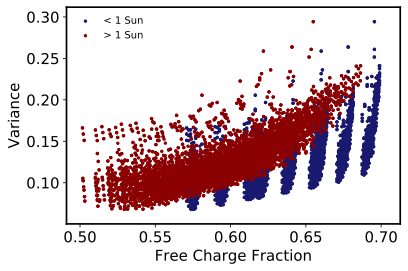

In [88]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.scatter(charge_ratio_low,variance,color = 'midnightblue',s = 6,label = '< 1 Sun')
ax.scatter(charge_ratio_1sun,variance,color = 'darkred',s = 6,label = '> 1 Sun')

for i in iter(ax.spines.values()):
    i.set_linewidth(1.7) 
ax.set_xlabel('Free Charge Fraction',fontsize = 15)
ax.set_ylabel('Variance',fontsize = 15)
#ax.set_xscale('log')
#ax.set_xlim(1e13,1e18)  
#ax.set_ylim(2.115, 2.1153)
ax.legend(frameon = False) 
fig.savefig('Error_calc_no_CT_new_new_0p5.svg', bbox_inches='tight')

No handles with labels found to put in legend.


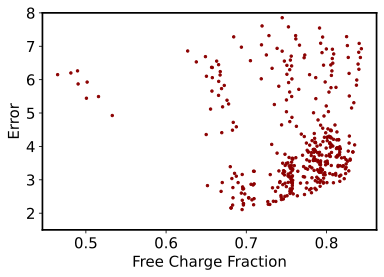

In [6]:
Paul_error = np.genfromtxt('error_plot.csv',delimiter=',')


fig = plt.figure()
ax = fig.add_subplot(111)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.scatter(Paul_error[:,0],Paul_error[:,1],color = 'darkred',s = 6,)
#ax.scatter(charge_ratio_1sun,variance,color = 'darkred',s = 6,label = '> 1 Sun')

for i in iter(ax.spines.values()):
    i.set_linewidth(1.7) 
ax.set_xlabel('Free Charge Fraction',fontsize = 15)
ax.set_ylabel('Error',fontsize = 15)
#ax.set_xscale('log')
#ax.set_xlim(1e13,1e18)  
ax.set_ylim(1.5, 8)
ax.legend(frameon = False) 
fig.savefig('Error_calc_no_CT_new_paul_model.svg', bbox_inches='tight')

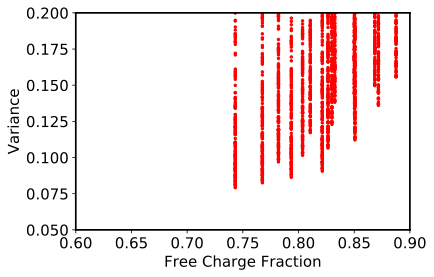

In [84]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.tick_params(axis='both', which='major', labelsize=15)
#ax.scatter(charge_ratio_low,variance,color = 'midnightblue',linewidth = 2,label = '0.01 Sun')
ax.scatter(charge_ratio_1sun,variance,color = 'r',s = 6,label = '1 Sun')

for i in iter(ax.spines.values()):
    i.set_linewidth(1.7) 
ax.set_xlabel('Free Charge Fraction',fontsize = 15)
ax.set_ylabel('Variance',fontsize = 15)
#ax.set_xscale('log')
ax.set_ylim(0.05,0.2) 
ax.set_xlim(0.6,0.9)  
#ax.legend(frameon = False)    
fig.savefig('variance_no_CT1.svg', bbox_inches='tight')

In [13]:
area = np.pi*(50e-6**2)
sun_int = 1e3 #per m^2
sun_diatom = sun_int*area #watts hitting diatom
boil_energy = 320e3 #per liter
time_1_diatom = boil_energy/sun_diatom
Number_diatoms_5_min = time_1_diatom/300



In [15]:
Number_diatoms_5_min

135812218.10508406